
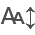

In [9]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import math
from statistics import NormalDist, mean
from collections import ChainMap
from statannotations.Annotator import Annotator
from IPython.display import HTML, display
import itables
itables.init_notebook_mode()
from itables import show
from seeg_utils import *
# import afidutils

In [4]:
root_dir = '../data/fcsv_new'

In [5]:
subjects = [identifier[:8] for identifier in os.listdir(root_dir) if "sub-" in identifier]
print(len(subjects))

228


In [6]:
frame_subjects = [sub for sub in subjects if sub.startswith('sub-F')]
print(len(frame_subjects))

0


# QC Subjects - Confirm Coordinate System

In [7]:
for subject in sorted(subjects):
  planned_fcsv = f'{root_dir}/{subject}/{subject}_planned.fcsv'
  actual_fcsv = f'{root_dir}/{subject}/{subject}_actual.fcsv'
  if glob.glob(planned_fcsv) and glob.glob(actual_fcsv):
    planned_coordsym, planned_headFin = seeg_utils.determineFCSVCoordSystem(planned_fcsv)
    if any(x in planned_coordsym for x in {'LPS','1'}):
      print(f'Planned is in LPS for {subject}')
    actual_coordsym, actual_headFin = seeg_utils.determineFCSVCoordSystem(actual_fcsv)
    if any(x in actual_coordsym for x in {'LPS','1'}):
      print(f'Actual is in LPS for {subject}')
  else:
    print(f"Files not found, review {subject}")

## QC Angles

In [6]:
# angle_new_dir = '/mnt/c/Users/athur/Documents/angles_run-02'
# angles = []
# review_subjects = []
# for sub in sorted(subjects):
#     print(sub)
#     new_angle_file = f'{angle_new_dir}/{sub}_clinical_info.csv'
#     sub_data = pd.read_csv(new_angle_file)
#     if 'entry_ang' in sub_data.columns:
#         angle_temp = sub_data[['label', 'entry_ang', 'skull_ang']]
#         angle_temp.insert(0, 'subject', sub)
#         angle_temp.loc[:, 'test_retest'] = angle_temp.loc[:, 'entry_ang'].astype(float) - angle_temp.loc[:, 'skull_ang'].astype(float)
#         angles.append(angle_temp)
#         if np.any(np.abs(angle_temp['test_retest'].values) > 10):
#             review_subjects.append(sub)
#     else:
#         angle_temp = sub_data[['label', 'skull_ang']]
#         angle_temp.insert(0, 'subject', sub)
#         angles.append(angle_temp)

# master_angles = pd.concat(angles, ignore_index = True)
# master_angles.to_csv(f'../output/mesh_angle_calculation.csv')

In [7]:
# master_angles

In [14]:
total_data = []
frame_data = []
subjects.pop('sub-P047')
for sub in sorted(subjects):
  elec_data=[]
  #print(sub)
  planned_fcsv = f'{root_dir}/{sub}/{sub}_planned.fcsv'
  actual_fcsv = f'{root_dir}/{sub}/{sub}_actual.fcsv'
  
  planned_mni = f'{root_dir}/{sub}/{sub}_space-MNI152NLin2009cSym_planned.fcsv'  
  actual_mni = f'{root_dir}/{sub}/{sub}_space-MNI152NLin2009cSym_actual.fcsv'

  if not glob.glob(planned_fcsv) or not glob.glob(actual_fcsv):
    print(f"Files not found, review {sub}")
    continue
  coord_sys,headFin=seeg_utils.determineFCSVCoordSystem(planned_fcsv, overwrite_fcsv=True)

  planned_df = pd.read_csv(planned_fcsv, skiprows=3, header=None)
  actual_df = pd.read_csv(actual_fcsv, skiprows=3, header=None)

  head_info=dict(ChainMap(*[{i:x} for i,x in enumerate(headFin)]))

  planned_df=planned_df.iloc[:,:].rename(columns=head_info).reset_index(drop=True)
  actual_df=actual_df.iloc[:,:].rename(columns=head_info).reset_index(drop=True)

  groups_planned, planned_all = seeg_utils.determine_groups(np.array(planned_df['label'].values))
  label_set=sorted(set(groups_planned), key=groups_planned.index)

  groups_actual, actual_all = seeg_utils.determine_groups(np.array(actual_df['label'].values))
  label_set_actual=sorted(set(groups_actual), key=groups_actual.index)

  for group in label_set_actual:
    elec_temp={}
    elec_temp['subject']=sub
    elec_temp['electrode']=group
    elec_temp['group']=group[1:]
    elec_temp['side']='L' if group.startswith('L') else 'R'

    planned_idx = [i for i,x in enumerate(planned_df['label'].values) if x.startswith(group)]
    elec_temp['plannedTipX']=planned_df.loc[planned_idx,'x'].values[0]
    elec_temp['plannedTipY']=planned_df.loc[planned_idx,'y'].values[0]
    elec_temp['plannedTipZ']=planned_df.loc[planned_idx,'z'].values[0]
    elec_temp['plannedEntryX']=planned_df.loc[planned_idx,'x'].values[1]
    elec_temp['plannedEntryY']=planned_df.loc[planned_idx,'y'].values[1]
    elec_temp['plannedEntryZ']=planned_df.loc[planned_idx,'z'].values[1]

    actual_idx=[i for i,x in enumerate(actual_df['label'].values) if x.startswith(group)]
    elec_temp['actualTipX']=actual_df.loc[actual_idx,'x'].values[0]
    elec_temp['actualTipY']=actual_df.loc[actual_idx,'y'].values[0]
    elec_temp['actualTipZ']=actual_df.loc[actual_idx,'z'].values[0]
    elec_temp['actualEntryX']=actual_df.loc[actual_idx,'x'].values[1]
    elec_temp['actualEntryY']=actual_df.loc[actual_idx,'y'].values[1]
    elec_temp['actualEntryZ']=actual_df.loc[actual_idx,'z'].values[1]

    mag = mag_vec(planned_df.loc[planned_idx,['x','y','z']].values[0],
                  planned_df.loc[planned_idx,['x','y','z']].values[1])
    norm = norm_vec(planned_df.loc[planned_idx,['x','y','z']].values[0],
                    planned_df.loc[planned_idx,['x','y','z']].values[1])
    plannedTipOffset=planned_df.loc[planned_idx,['x','y','z']].values[1]-(norm*(mag-1))

    elec_temp['plannedOffsetX']=plannedTipOffset[0]
    elec_temp['plannedOffsetY']=plannedTipOffset[1]
    elec_temp['plannedOffsetZ']=plannedTipOffset[2]

    # elec_temp['plannedOffsetX']=elec_temp['plannedTipX']
    # elec_temp['plannedOffsetY']=elec_temp['plannedTipY']
    # elec_temp['plannedOffsetZ']=elec_temp['plannedTipZ']

    xyz_planned_entry = np.array([elec_temp['plannedEntryX'], elec_temp['plannedEntryY'], elec_temp['plannedEntryZ']])
    xyz_actual_entry = np.array([elec_temp['actualEntryX'], elec_temp['actualEntryY'], elec_temp['actualEntryZ']]).T
    xyz_planned_target = np.array([elec_temp['plannedOffsetX'], elec_temp['plannedOffsetY'], elec_temp['plannedOffsetZ']]).T
    xyz_actual_target = np.array([elec_temp['actualTipX'], elec_temp['actualTipY'], elec_temp['actualTipZ']]).T

    elec_temp['euclid_dist_target'] = seeg_utils.euclidianDistanceCalc(xyz_planned_target, xyz_actual_target)
    elec_temp['euclid_dist_entry'] = seeg_utils.euclidianDistanceCalc(xyz_planned_entry, xyz_actual_entry)
    elec_temp['radial_dist_target'] = seeg_utils.radialDistanceCalc(xyz_planned_target, xyz_actual_entry, xyz_actual_target)
    elec_temp['radial_dist_entry'] = seeg_utils.radialDistanceCalc(xyz_planned_entry, xyz_actual_entry, xyz_actual_target)

    if not np.array_equal(np.round(xyz_actual_target,2), np.round(xyz_planned_target,2)):
      try:
        elec_temp['radial_angle'] = seeg_utils.ptLineAngleCalc(xyz_actual_target, xyz_planned_entry, xyz_planned_target)
        elec_temp['line_angle'] = seeg_utils.lineLineAngleCalc(xyz_actual_entry, xyz_actual_target, xyz_planned_entry, xyz_planned_target)
      except:
        pass
    # if glob.glob(f'{root_dir}/{sub}/{sub}_clinical_info.csv'):
    #   df_clinical = pd.read_csv(f'{root_dir}/{sub}/{sub}_clinical_info.csv')
    #   if 'entry_ang' in df_clinical.columns:
    #     elec_temp['entry_ang'] = df_clinical.loc[df_clinical['label'] == group]['entry_ang'].values[0]
    #   else:
    #     elec_temp['entry_ang'] = np.nan
    #   if 'scalp_dura'in df_clinical.columns:  
    #     elec_temp['scalp_dura'] = df_clinical.loc[df_clinical['label'] == group]['scalp_dura'].values[0]
    if glob.glob(planned_mni):
        plan_mni_df = pd.read_csv(planned_mni, skiprows = 3, header = None)
        actual_mni_df = pd.read_csv(actual_mni, skiprows = 3, header = None)
        
        plan_mni_df = plan_mni_df.iloc[:,:].rename(columns=head_info).reset_index(drop=True)
        actual_mni_df = actual_mni_df.iloc[:,:].rename(columns=head_info).reset_index(drop=True)
        
        planned_idx = [i for i,x in enumerate(plan_mni_df['label'].values) if x.startswith(group)]
        elec_temp['plannedTipX_MNI']=plan_mni_df.loc[planned_idx,'x'].values[0]
        elec_temp['plannedTipY_MNI']=plan_mni_df.loc[planned_idx,'y'].values[0]
        elec_temp['plannedTipZ_MNI']=plan_mni_df.loc[planned_idx,'z'].values[0]
        elec_temp['plannedEntryX_MNI']=plan_mni_df.loc[planned_idx,'x'].values[1]
        elec_temp['plannedEntryY_MNI']=plan_mni_df.loc[planned_idx,'y'].values[1]
        elec_temp['plannedEntryZ_MNI']=plan_mni_df.loc[planned_idx,'z'].values[1]

        mag = mag_vec(plan_mni_df.loc[planned_idx,['x','y','z']].values[0],
                      plan_mni_df.loc[planned_idx,['x','y','z']].values[1])
        norm = norm_vec(plan_mni_df.loc[planned_idx,['x','y','z']].values[0],
                        plan_mni_df.loc[planned_idx,['x','y','z']].values[1])
        plannedTipOffset_MNI=plan_mni_df.loc[planned_idx,['x','y','z']].values[1]-(norm*(mag-1))

        elec_temp['plannedOffsetX_MNI']=plannedTipOffset_MNI[0]
        elec_temp['plannedOffsetY_MNI']=plannedTipOffset_MNI[1]
        elec_temp['plannedOffsetZ_MNI']=plannedTipOffset_MNI[2]
        
        actual_idx=[i for i,x in enumerate(actual_mni_df['label'].values) if x.startswith(group)]
        elec_temp['actualTipX_MNI']=actual_mni_df.loc[actual_idx,'x'].values[0]
        elec_temp['actualTipY_MNI']=actual_mni_df.loc[actual_idx,'y'].values[0]
        elec_temp['actualTipZ_MNI']=actual_mni_df.loc[actual_idx,'z'].values[0]
        elec_temp['actualEntryX_MNI']=actual_mni_df.loc[actual_idx,'x'].values[1]
        elec_temp['actualEntryY_MNI']=actual_mni_df.loc[actual_idx,'y'].values[1]
        elec_temp['actualEntryZ_MNI']=actual_mni_df.loc[actual_idx,'z'].values[1]
    
    elec_data.append(elec_temp)
      
  elec_data_raw=pd.DataFrame(elec_data)
  elec_table=elec_data_raw[['electrode','euclid_dist_target', 'radial_dist_target', 'euclid_dist_entry','radial_dist_entry','radial_angle','line_angle']].round(2)

  # elec_table.to_csv(f'{root_dir}/{sub}/{sub}_accuracy.csv', index=False)

  if sub.startswith('sub-F'):
    frame_data.append(elec_data)
  else:
    total_data.append(elec_data)


TypeError: 'str' object cannot be interpreted as an integer

In [12]:
sub

'sub-P047'

In [9]:
flattened_data = [item for sublist in total_data for item in sublist]

robot = pd.DataFrame(flattened_data)

robot = robot.explode(['electrode', 'group', 'side', 'radial_angle', 'line_angle',
                     'euclid_dist_entry',  'radial_dist_entry', 'euclid_dist_target', 'radial_dist_target'])


# flattened_frame = [item for sublist in frame_data for item in sublist]

# frame = pd.DataFrame(flattened_frame)

# frame = frame.explode(['electrode', 'group', 'side', 'radial_angle', 'line_angle',
#                      'euclid_dist_entry',  'radial_dist_entry', 'euclid_dist_target', 'radial_dist_target'])

In [10]:
robot_mni = robot[['subject', 'electrode', 'group', 'side', 'euclid_dist_target',
       'euclid_dist_entry', 'radial_dist_target', 'radial_dist_entry',
       'radial_angle', 'line_angle', 'plannedTipX_MNI', 'plannedTipY_MNI',
       'plannedTipZ_MNI', 'plannedEntryX_MNI', 'plannedEntryY_MNI',
       'plannedEntryZ_MNI', 'actualTipX_MNI', 'actualTipY_MNI',
       'actualTipZ_MNI', 'actualEntryX_MNI', 'actualEntryY_MNI',
       'actualEntryZ_MNI']]
# frame_mni = frame[['subject', 'electrode', 'group', 'side', 'euclid_dist_target',
#        'euclid_dist_entry', 'radial_dist_target', 'radial_dist_entry',
#        'radial_angle', 'line_angle', 'plannedTipX_MNI', 'plannedTipY_MNI',
#        'plannedTipZ_MNI', 'plannedEntryX_MNI', 'plannedEntryY_MNI',
#        'plannedEntryZ_MNI', 'actualTipX_MNI', 'actualTipY_MNI',
#        'actualTipZ_MNI', 'actualEntryX_MNI', 'actualEntryY_MNI',
#        'actualEntryZ_MNI']]
#robot_mni

In [11]:
# robot_mni.to_csv(f'../output/2025_SEEG_robot_accuracy_MNIcoords.csv', index=False)
# frame_mni.to_csv(f'../output/2025_SEEG_frame_accuracy_MNIcoords.csv', index=False)

In [12]:
# robot.to_csv(f'../output/2025_SEEG_robot_accuracy.csv', index=False)
# frame.to_csv(f'../output/2025_SEEG_frame_accuracy.csv', index=False)

In [13]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return data[data[column] <= upper_bound], upper_bound

df_clean_target, ub_target = remove_outliers_iqr(robot_mni, 'euclid_dist_target')
df_clean_both, ub_entry = remove_outliers_iqr(df_clean_target, 'euclid_dist_entry')

In [14]:
df_clean = df_clean_both.copy()

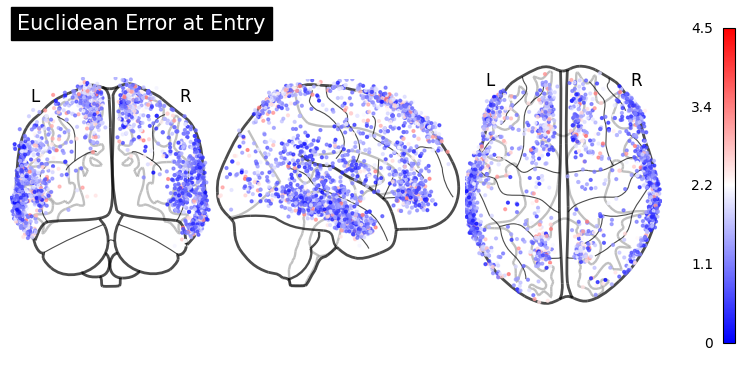

In [15]:
from nilearn import plotting
import matplotlib
import matplotlib.pyplot as plt
coords_entry = df_clean_both[['actualEntryX_MNI', 'actualEntryY_MNI', 'actualEntryZ_MNI']].values
error = df_clean_both['euclid_dist_entry'].values
norm = plt.Normalize(vmin = np.min(error), vmax = np.max(error))

display = plotting.plot_markers(error, 
                                coords_entry, 
                                node_cmap = plt.cm.bwr,
                                title = 'Euclidean Error at Entry',
                                node_vmax = 4.5,
                                node_vmin = 0
                               )
plt.savefig('../output/entry_points_error.png', dpi = 300)
plt.show()

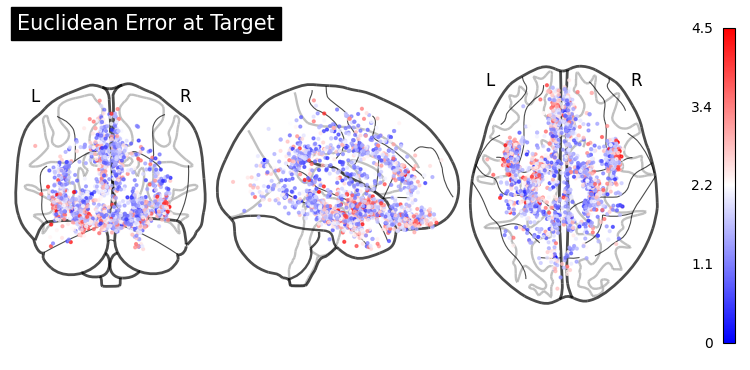

In [16]:
coords_target = df_clean_both[['actualTipX_MNI', 'actualTipY_MNI', 'actualTipZ_MNI']].values
error = df_clean_both['euclid_dist_target'].values
norm = plt.Normalize(vmin = np.min(error), vmax = np.max(error))

display = plotting.plot_markers(error, 
                                coords_target, 
                                node_cmap = plt.cm.bwr,
                                title = 'Euclidean Error at Target',
                                node_vmax = 4.5,
                                node_vmin = 0
                               )
plt.savefig('../output/target_points_error.png', dpi = 300)
plt.show()

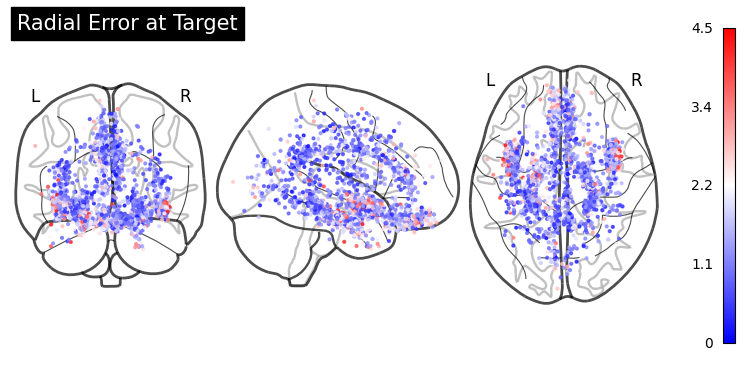

In [17]:
coords_target = df_clean_both[['actualTipX_MNI', 'actualTipY_MNI', 'actualTipZ_MNI']].values
radial_error = df_clean_both['radial_dist_target'].values
# norm = plt.Normalize(vmin = np.min(radial_error), vmax = np.max(error))

display = plotting.plot_markers(radial_error, 
                                coords_target, 
                                node_cmap = plt.cm.bwr,
                                title = 'Radial Error at Target',
                                node_vmax = 4.5,
                                node_vmin = 0
                               )
plt.savefig('../output/target_points_radial_error.png', dpi = 300)
plt.show()

In [18]:
common_targets = df_clean['group'].value_counts().nlargest(25).index
data = df_clean[df_clean['group'].isin(common_targets)]

print(len(common_targets))
common_targets

25


Index(['AHc', 'PHc', 'AIn', 'Am', 'PIn', 'OFr', 'PCg', 'ACg', 'POFr', 'AOFr',
       'TePo', 'FrOp', 'Cg', 'ASSMA', 'PTe', 'SMA', 'PSSMA', 'MIn', 'Lg',
       'PrC', 'ASMA', 'SSMA', 'AFr', 'OpIn', 'MidIn'],
      dtype='object', name='group')

In [19]:
for target in common_targets:
    data = df_clean[df_clean['group'] == target]
    coords_target = data[['actualTipX_MNI', 'actualTipY_MNI', 'actualTipZ_MNI']].values
    coords_entry = data[['actualEntryX_MNI', 'actualEntryY_MNI', 'actualEntryZ_MNI']].values
    
    euclid_error_target = data['euclid_dist_target'].values
    euclid_error_entry = data['euclid_dist_entry'].values
    
    coords = np.vstack([coords_target, coords_entry])
    euclid_error = np.vstack([euclid_error_target, euclid_error_entry])
    # norm = plt.Normalize(vmin = np.min(radial_error), vmax = np.max(error))
    
    # display = plotting.plot_markers(euclid_error, 
    #                                 coords, 
    #                                 node_cmap = plt.cm.bwr,
    #                                 title = f'Euclidean Error for {target}',
    #                                 node_size = 5,
    #                                 node_vmin = 0,
    #                                 node_vmax = 4.5
    #                                )
    # plt.savefig(f'../output/electrode_plots/{target}_euclidean_error.png', dpi = 300)
    # plt.show()

In [20]:
# for target in common_targets:
#     data = df_clean[df_clean['group'] == target]
#     coords_target = data[['actualTipX_MNI', 'actualTipY_MNI', 'actualTipZ_MNI']].values
#     coords_entry = data[['actualEntryX_MNI', 'actualEntryY_MNI', 'actualEntryZ_MNI']].values
    
#     euclid_error_target = data['radial_dist_target'].values
#     euclid_error_entry = data['radial_dist_entry'].values
    
#     coords = np.vstack([coords_target, coords_entry])
#     euclid_error = np.vstack([euclid_error_target, euclid_error_entry])
#     # norm = plt.Normalize(vmin = np.min(radial_error), vmax = np.max(error))
    
#     display = plotting.plot_markers(euclid_error, 
#                                     coords, 
#                                     node_cmap = plt.cm.bwr,
#                                     title = f'Euclidean Error for {target}',
#                                     node_size = 5,
#                                     node_vmin = 0,
#                                     node_vmax = 4.5
#                                    )
#     plt.savefig(f'../output/electrode_plots/{target}_radial_error.png', dpi = 300)
#     # plt.show()

In [21]:
# from io import BytesIO
# from PIL import Image

# images = []
# for target in common_targets:
#     data = df_clean[df_clean['group'] == target]
#     coords_target = data[['actualTipX_MNI', 'actualTipY_MNI', 'actualTipZ_MNI']].values
#     coords_entry = data[['actualEntryX_MNI', 'actualEntryY_MNI', 'actualEntryZ_MNI']].values
    
#     euclid_error_target = data['euclid_dist_target'].values
#     euclid_error_entry = data['euclid_dist_entry'].values
    
#     coords = np.vstack([coords_target, coords_entry])
#     euclid_error = np.vstack([euclid_error_target, euclid_error_entry])
#     # norm = plt.Normalize(vmin = np.min(radial_error), vmax = np.max(error))

#     display = plotting.plot_markers(euclid_error, 
#                                     coords, 
#                                     node_cmap = plt.cm.bwr,
#                                     title = f'Euclidean Error for {target}',
#                                     node_size = 5
#                                    )
#     buf = BytesIO()
#     display.savefig(buf, format='png', bbox_inches='tight', dpi=250)
#     display.close()
#     buf.seek(0)
#     img = Image.open(buf).convert("RGB")
#     images.append(np.array(img))
#     # plt.savefig(f'../output/{target}_euclidean_error.png')
#     # plt.show()

# # Grid layout
# num_cols = 3
# num_rows = int(np.ceil(len(images) / num_cols))

# # Pad with blank white images if needed
# img_h, img_w, _ = images[0].shape
# blank_img = np.ones((img_h, img_w, 3), dtype=np.uint8) * 255
# while len(images) < num_rows * num_cols:
#     images.append(blank_img)

# # Create row-wise image arrays
# rows = [
#     np.concatenate(images[i*num_cols:(i+1)*num_cols], axis=1)
#     for i in range(num_rows)
# ]

# # Stack rows vertically into one big image
# grid_img = np.concatenate(rows, axis=0)

# # Display and save the final grid
# plt.figure(figsize=(num_cols * 4, num_rows * 4))
# plt.imshow(grid_img)
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("../output/glass_brain_grid.png", dpi=250, bbox_inches='tight')
# plt.show()

In [22]:
# robot.to_csv(f'../output/2025_SEEG_robot_accuracy.csv', index=False)
# frame.to_csv(f'../output/2025_SEEG_frame_accuracy.csv', index=False)

robot = pd.read_csv(f'../output/2025_SEEG_robot_accuracy.csv')
frame = pd.read_csv(f'../output/2025_SEEG_frame_accuracy.csv')

vars_of_interest = ['subject', 'electrode', 'group', 'side', 'euclid_dist_entry',  'radial_dist_entry', 
                    'euclid_dist_target', 'radial_dist_target', 'radial_angle', 'line_angle']
# show(robot[vars_of_interest], maxBytes = 0) #working in notebook

In [23]:
html = itables.to_html_datatable(robot[vars_of_interest], maxBytes = 0)
display(HTML(html))

TypeError: 'OrthoProjector' object is not callable

In [ ]:
show(frame[vars_of_interest], maxBytes = 0) #working in notebook

In [ ]:
variables = ['mean', 'std']
features = ['euclid_dist_entry', 'radial_dist_entry', 'euclid_dist_target', 
 'radial_dist_target', 'radial_angle', 'line_angle']

# agg_args = dict(zip(features, variables))
# print(agg_args)

agg_args = {feature: variables for feature in features}

robot_electrode = robot.groupby('group')
robot_hemi = robot.groupby('side')

In [ ]:
robot_elec_stat = robot_electrode[features].agg(['mean', 'std'])
robot_elec_counts = robot_electrode.size().to_frame(name='count')

# Flatten column names
robot_elec_stat.columns = ['_'.join(col).strip() for col in robot_elec_stat.columns.values]

# Combine count with stats
summary = pd.concat([robot_elec_counts, robot_elec_stat], axis=1)

# Display final summary
# show(summary)

In [ ]:
html_summary = itables.to_html_datatable(summary, maxBytes = 0)
display(HTML(html_summary))

In [ ]:
robot_hemi_stat = robot_hemi[features].agg(['mean', 'std'])
robot_hemi_stat